(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [106]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic

# Import package to save outputs
import BSON

# Import statistical functions
import Random
import StatsBase
import Distributions

# Import basic math
import LinearAlgebra

# Import ML libraries
import Flux
import NNlib
import SimpleChains
import Zygote

# Import library to access classic ML datasets
import MLDatasets

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Differential geometry of latent space

`[explanation here]`

## Simple 3D example

to begin our exploration of the differential geometry ideas, let's work with a
simple example. Let us define a function of the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}
$$

In [2]:
# Define function
f(x₁, x₂) = exp(-(x₁^2 + x₂^2))

f (generic function with 1 method)

Let's generate a random set of numbers sampling uniformly in a circle.

In [29]:
Random.seed!(42)

# Define number of points to sample
n_sample = 1_000

# Defien radius
radius = 3

# Sample random radius
r_rand = radius .* sqrt.(Random.rand(n_sample))

# Sample random angles
θ_rand = 2π .* Random.rand(n_sample) 

# Convert form polar to cartesian coordinates
x_rand = Float32.(r_rand .* cos.(θ_rand))
y_rand = Float32.(r_rand .* sin.(θ_rand))
# Feed numbers to function
z_rand = f.(x_rand, y_rand)

# Compile data into matrix
data = Matrix(hcat(x_rand, y_rand, z_rand)')

3×1000 Matrix{Float32}:
 -1.1037    -0.130005   1.22947    …  -1.85835      2.19925      0.88909
  0.586526  -1.69648    0.903149      -1.71827     -1.69536      0.856582
  0.20968    0.0553015  0.0975618      0.00165177   0.000447911  0.217792

Let's look at the input and output space

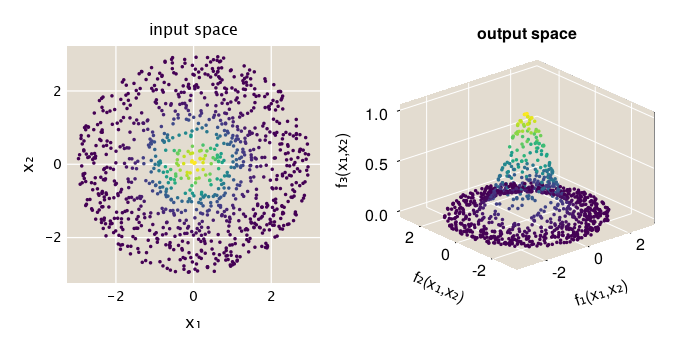

In [30]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for input space
ax_input = Axis(
    gl[1, 1],
    xlabel="x₁",
    ylabel="x₂",
    title="input space"
)

# Plot input space
scatter!(
    ax_input,
    x_rand,
    y_rand,
    markersize=5,
    color=z_rand,
    colormpa=:viridis
)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_output,
    data[1, :],
    data[2, :],
    data[3, :],
    markersize=5,
    color=data[3, :],
    colormap=:viridis,
)

# Separate axis
colgap!(gl, 50)

fig

### Training simple autoencoder

Given this 3D data, we can train an autoencoder with a 2D latent space. This
training was done with the `SimpleChains.jl` library. Let's import the results.

In [78]:
# Define number of epohcs
n_epoch = 500_000
# Define how often error should be computd
n_error = 5_000

# Define filename
fname = "$(git_root())/code/processing/ae_3Dpeak/output/$(n_epoch)_epoch/" *
        "ae_2dimensions.bson"
# Load model
ae = BSON.load(fname)[:ae]
# Load mean squared error
mse = BSON.load(fname)[:mse_flux]
# Load data
data = BSON.load(fname)[:data];
# Load standardized data
data_std = BSON.load(fname)[:data_std];

Let's look at the error over the epochs.

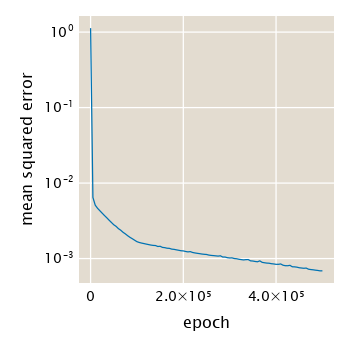

In [79]:
# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="epoch",
    ylabel="mean squared error",
    yscale=log10,
)

# Plot error
lines!(ax, [collect(1:n_error:n_epoch); [n_epoch]], mse)

fig

Let's look at the resemblance between the input and the output of this
autoencoder.

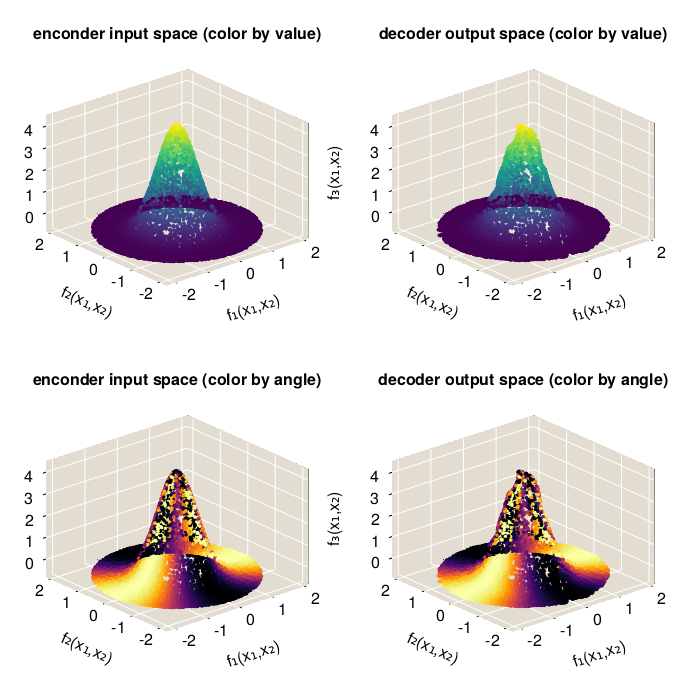

In [104]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 2 * 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

ax = [
    Axis3(
        gl[i, j],
        xlabel="f₁(x₁,x₂)",
        ylabel="f₂(x₁,x₂)",
        zlabel="f₃(x₁,x₂)",
        xypanelcolor="#E3DCD0",
        xzpanelcolor="#E3DCD0",
        yzpanelcolor="#E3DCD0",
        xgridcolor=:white,
        ygridcolor=:white,
        zgridcolor=:white,
    ) for i = 1:2 for j = 1:2
]

# Reshape axis
ax = permutedims(reshape(ax, 2, 2), (2, 1))

# Plot output space (color by z-value)
scatter!(
    ax[1, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 1].title = "enconder input space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color= atan.(data_std[1, :].^2, data_std[2, :].^2),
    colormap=:inferno,
)

# Add title
ax[2, 1].title = "enconder input space (color by angle)"

# Pass data through autoencoder
data_ae = ae(data_std)

# Plot output space (color by z-value)
scatter!(
    ax[1, 2],
    data_ae[1, :],
    data_ae[2, :],
    data_ae[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 2].title = "decoder output space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 2],
    data_ae[1, :],
    data_ae[2, :],
    data_ae[3, :],
    markersize=5,
    color= atan.(data_std[1, :].^2, data_std[2, :].^2),
    colormap=:inferno,
)

# Add title
ax[2, 2].title = "decoder output space (color by angle)"


fig

The autoencoder is able to reproduce the data with high fidelity the input space
with the 2D latenet space.

With this autoencoder in hand, let's split the enconder and decoder sections.

In [80]:
# Extract encoder
encoder = ae[1:4]

# Extract decoder section
decoder = ae[5:end]

Chain(
  Dense(2 => 20, sigmoid_fast),         # 60 parameters
  Dense(20 => 20, sigmoid_fast),        # 420 parameters
  Dense(20 => 20, sigmoid_fast),        # 420 parameters
  Dense(20 => 3),                       # 63 parameters
)                   # Total: 8 arrays, 963 parameters, 4.262 KiB.

Next, let's map the input data into the latent space.

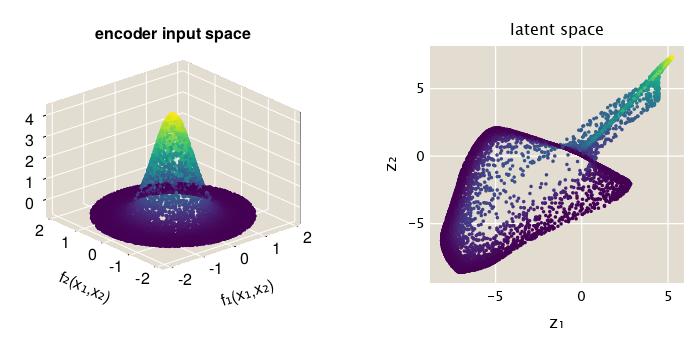

In [152]:
# Map input data to latent space
data_latent = encoder(data_std)

# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for output space
ax_input = Axis3(
    gl[1, 1],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="encoder input space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_input,
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add axis for latent space
ax_latent = Axis(
    gl[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space"
)

# Plot latent space
scatter!(
    ax_latent,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

# Separate axis
colgap!(gl, 50)

fig

In [163]:
# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-8.5, 7.5, n_range)

# Initialize matrix to save metric
latent_metric = Matrix{Float32}(undef, n_range, n_range)

# Loop through first latent variable
for (i, x) in enumerate(z1)
    # Loop through second latent variable
    for (j, y) in enumerate(z2)
        # Compute Jacobian
        jac = first(Zygote.jacobian(decoder, [x, y]))
        # Compute and save metric
        latent_metric[i, j] = sqrt(LinearAlgebra.det(jac' * jac))
    end # for
end # for

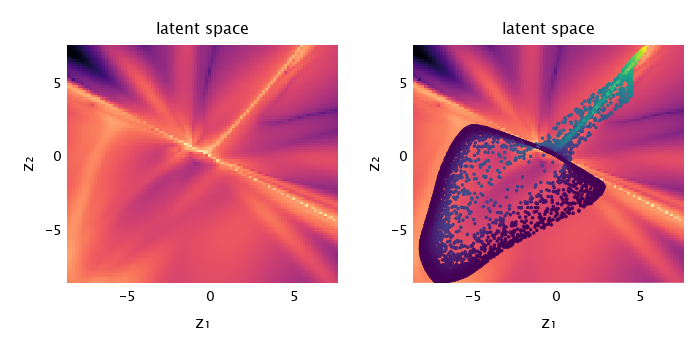

In [167]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add axis for latent space
ax1 = Axis(
    fig[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space"
)

# Plot metric as a heatmap
heatmap!(ax1, z1, z2, log.(latent_metric), colormap=:magma)


# Add axis for latent space
ax2 = Axis(
    fig[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space"
)

# Plot metric as a heatmap
heatmap!(ax2, z1, z2, log.(latent_metric), colormap=:magma)

# Plot latent space
scatter!(
    ax2,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

fig